In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Temperature/Madaripur.csv')
#the daily dataset
print(df.shape)
df.head()

(444, 4)


,DATE,Max Temp,Min Temp,MEAN
0,1/31/1977,28.5,10.5,19.50
1,2/28/1977,31.9,14.0,22.95
2,3/31/1977,36.2,21.0,28.60
3,4/30/1977,34.2,22.3,28.25
4,5/31/1977,34.7,23.5,29.10


In [4]:
#checking types
df.pop('Max Temp')
df.pop('Min Temp')
df.dtypes

DATE     object
MEAN    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

           DATE   MEAN
0     1/31/1977  19.50
1     2/28/1977  22.95
2     3/31/1977  28.60
3     4/30/1977  28.25
4     5/31/1977  29.10
..          ...    ...
439   8/31/2013  30.10
440   9/30/2013  30.70
441  10/31/2013  29.35
442  11/30/2013  25.15
443  12/31/2013  21.40

[444 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,DATE,MEAN
0,1/31/1977,19.50
1,2/28/1977,22.95
2,3/31/1977,28.60
3,4/30/1977,28.25
4,5/31/1977,29.10


In [8]:
df.tail()

,DATE,MEAN
439,8/31/2013,30.10
440,9/30/2013,30.70
441,10/31/2013,29.35
442,11/30/2013,25.15
443,12/31/2013,21.40


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
#df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,MEAN
DATE,
1/31/1977,19.50
2/28/1977,22.95
3/31/1977,28.60
4/30/1977,28.25
5/31/1977,29.10


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Madaripur_monthly.csv")

(444, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1977-01-31 00:00:00
End Date: 2013-12-31 00:00:00
Total month: 444
Total year: 37


Data Visulalization
----------

About Data

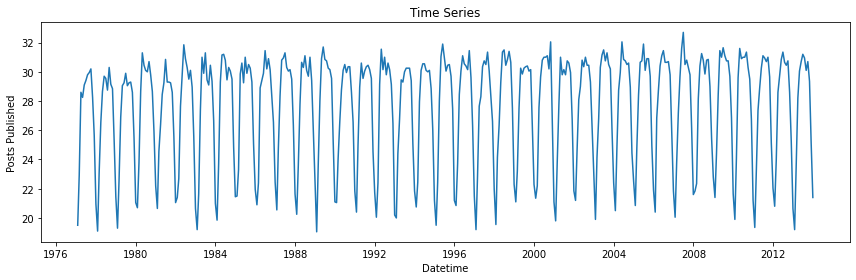

In [12]:
# 7.Plotting the time series
monthly['MEAN'] = monthly['MEAN'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(348, 1), Validation=(96, 1)


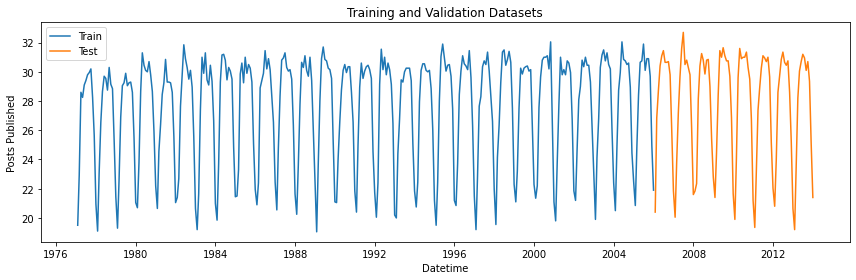

In [13]:
train = monthly.loc[:'2005-12-31']
valid = monthly.loc['2006-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

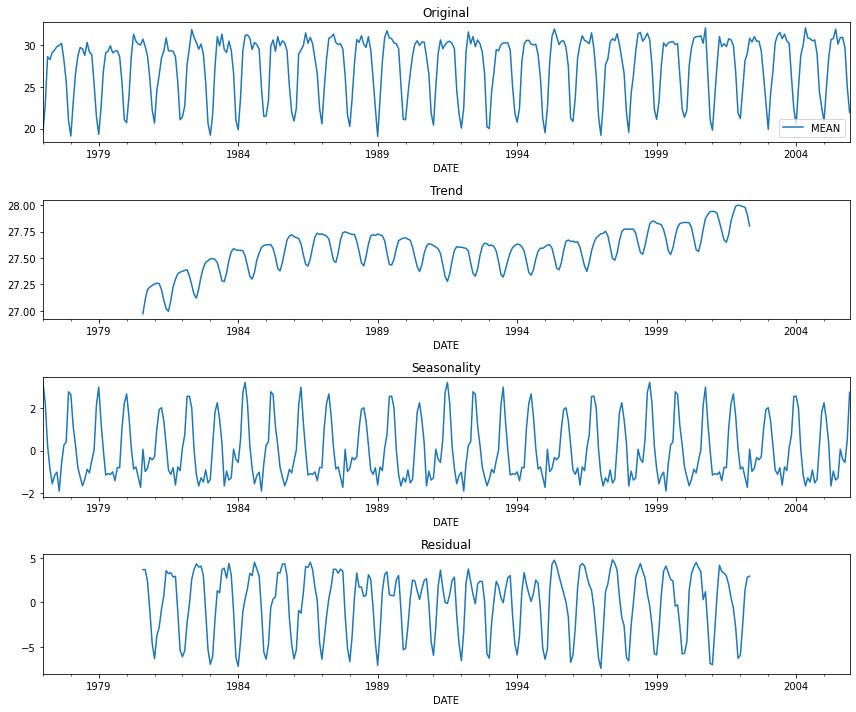

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

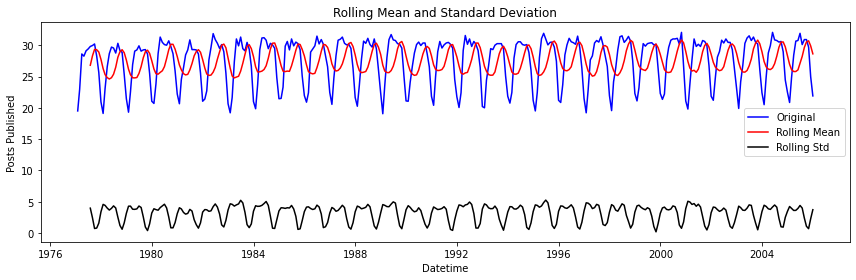

Results of Dickey-Fuller Test:
Test Statistic                  -2.911199
P-Value                          0.044061
#Lags Used                      13.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MEAN   No. Observations:                  348
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -580.294
Date:                Mon, 07 Nov 2022   AIC                           1178.588
Time:                        08:18:44   BIC                           1213.232
Sample:                    01-31-1977   HQIC                          1192.381
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8845      0.051     17.207      0.000       0.784       0.985
ar.L2         -0.4057      0.078     -5.168      0.000      -0.560      -0.252
ar.L3         -0.2511      0.082     -3.044      0.0

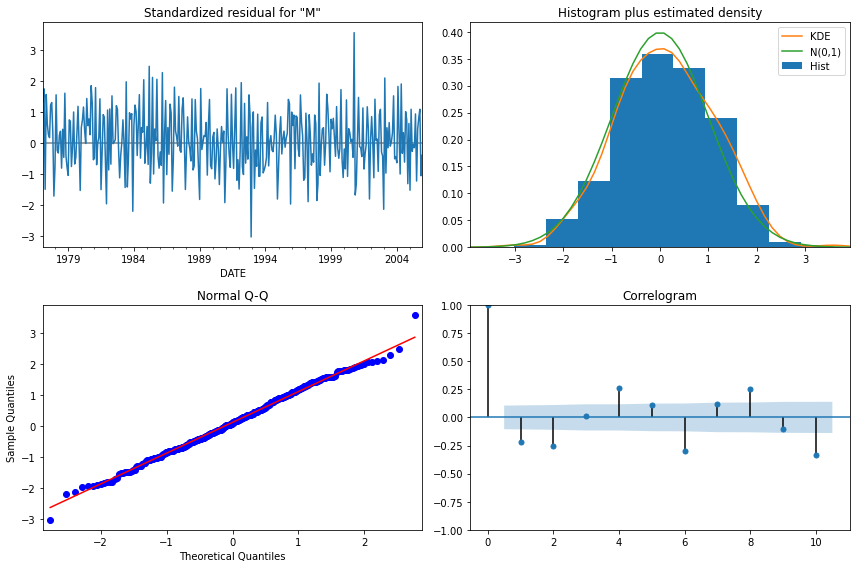

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

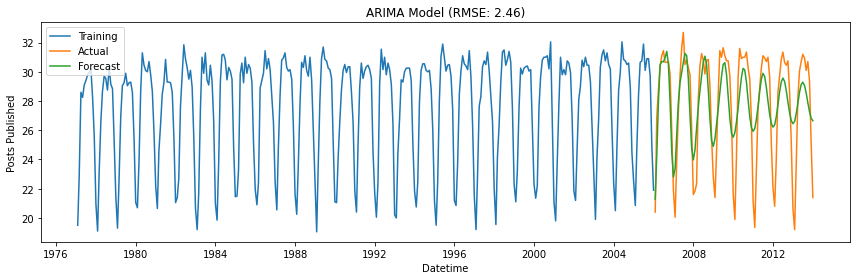

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2006-01-31    21.287442
2006-02-28    24.209274
2006-03-31    27.971857
2006-04-30    30.454497
2006-05-31    30.704750
                ...    
2013-08-31    28.548958
2013-09-30    27.892785
2013-10-31    27.267410
2013-11-30    26.818023
2013-12-31    26.652737
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.46155636353601


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                               MEAN   No. Observations:                  348
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -372.923
Date:                            Mon, 07 Nov 2022   AIC                            779.846
Time:                                    08:21:00   BIC                            844.686
Sample:                                01-31-1977   HQIC                           805.696
                                     - 12-31-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1693      0.063      2.699      0.007       0.046       0.292
ar.L2          0.0580      0.064   

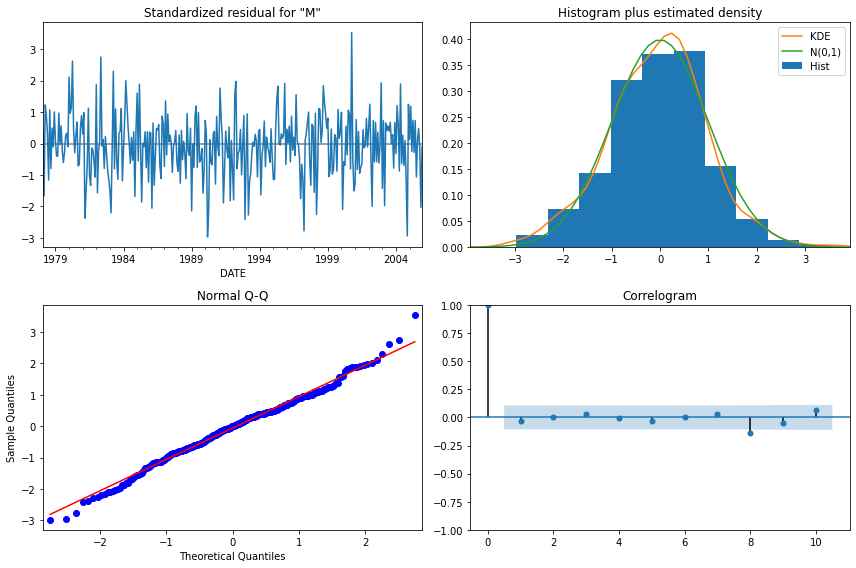

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

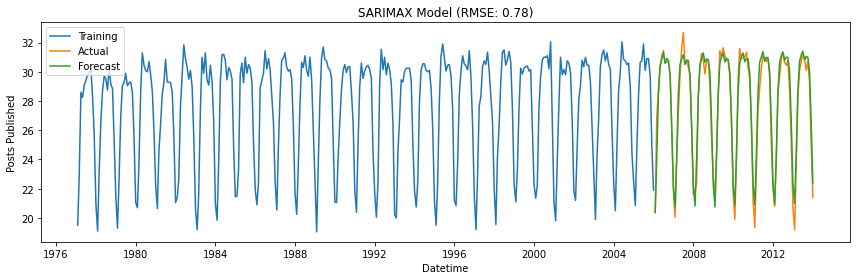

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2006-01-31    20.353276
2006-02-28    24.039602
2006-03-31    28.442890
2006-04-30    30.334944
2006-05-31    30.852682
                ...    
2013-08-31    31.048331
2013-09-30    31.001504
2013-10-31    30.055199
2013-11-30    26.635327
2013-12-31    22.385973
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.7787030411246202


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv('Madaripur_monthly.csv')

In [32]:

#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1977-01-31,19.50
1,1977-02-28,22.95
2,1977-03-31,28.60
3,1977-04-30,28.25
4,1977-05-31,29.10


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxdc8v4s/278p1s6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxdc8v4s/gcwpf7be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70183', 'data', 'file=/tmp/tmpgxdc8v4s/278p1s6r.json', 'init=/tmp/tmpgxdc8v4s/gcwpf7be.json', 'output', 'file=/tmp/tmpgxdc8v4s/prophet_modelcg_z2hic/prophet_model-20221107082102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 11, freq='M')
print(prophet_forecast_date)

            ds
0   1977-01-31
1   1977-02-28
2   1977-03-31
3   1977-04-30
4   1977-05-31
..         ...
571 2024-08-31
572 2024-09-30
573 2024-10-31
574 2024-11-30
575 2024-12-31

[576 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1977-01-31,26.797814,18.525617,20.233428,26.797814,26.797814,-7.434842,-7.434842,-7.434842,-7.434842,-7.434842,-7.434842,0.0,0.0,0.0,19.362972
1,1977-02-28,26.805353,21.871776,23.617222,26.805353,26.805353,-4.026950,-4.026950,-4.026950,-4.026950,-4.026950,-4.026950,0.0,0.0,0.0,22.778403
2,1977-03-31,26.813700,26.412689,28.100591,26.813700,26.813700,0.463050,0.463050,0.463050,0.463050,0.463050,0.463050,0.0,0.0,0.0,27.276750
3,1977-04-30,26.821778,28.439014,30.172133,26.821778,26.821778,2.440014,2.440014,2.440014,2.440014,2.440014,2.440014,0.0,0.0,0.0,29.261792
4,1977-05-31,26.830125,28.798893,30.559261,26.830125,26.830125,2.898798,2.898798,2.898798,2.898798,2.898798,2.898798,0.0,0.0,0.0,29.728924


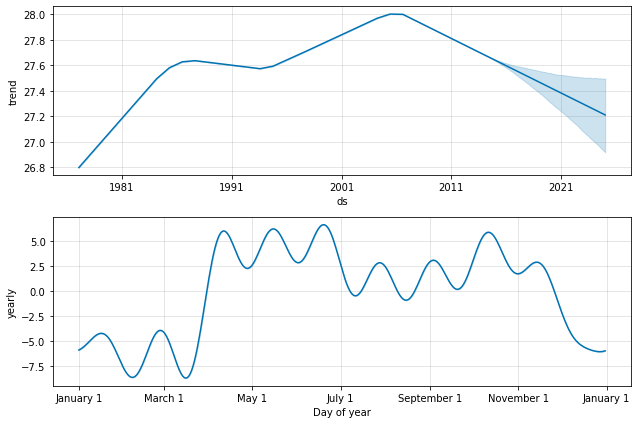

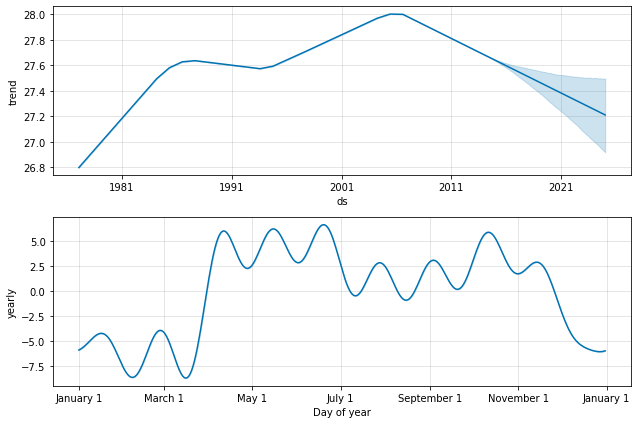

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1977-01-31  19.362972
1977-02-28  22.778403
1977-03-31  27.276750
1977-04-30  29.261792
1977-05-31  29.728924
...               ...
2024-08-31  30.065211
2024-09-30  30.095159
2024-10-31  28.932154
2024-11-30  25.340288
2024-12-31  21.251294

[576 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1977-01-31    19.362972
1977-02-28    22.778403
1977-03-31    27.276750
1977-04-30    29.261792
1977-05-31    29.728924
                ...    
2024-08-31    30.065211
2024-09-30    30.095159
2024-10-31    28.932154
2024-11-30    25.340288
2024-12-31    21.251294
Name: yhat, Length: 576, dtype: float64


In [40]:
print(valid)

             MEAN
DATE             
2006-01-31  20.40
2006-02-28  26.85
2006-03-31  28.75
2006-04-30  30.40
2006-05-31  31.10
...           ...
2013-08-31  30.10
2013-09-30  30.70
2013-10-31  29.35
2013-11-30  25.15
2013-12-31  21.40

[96 rows x 1 columns]


In [41]:
forecast_prophet_valid=full_forecast_prophet['2006-01-31':'2013-12-31']

In [42]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.6520779456147783


-----------------

MODEL Comparison
----------

Testing

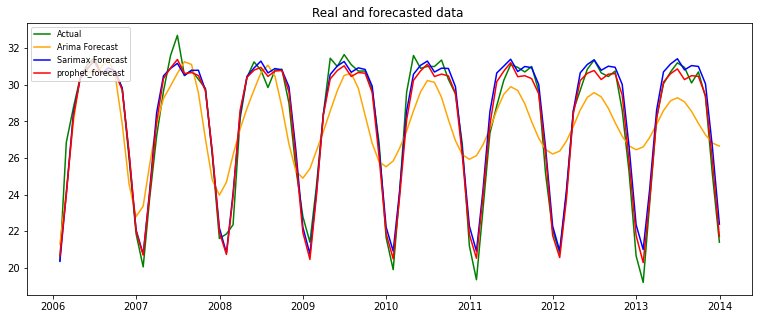

In [43]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

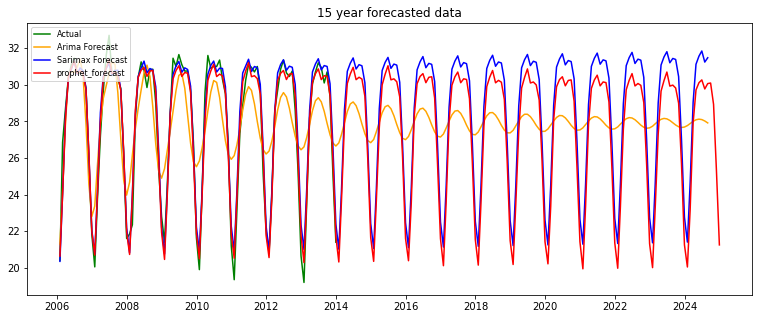

In [44]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+128)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+128)
forecast_10_prophet=full_forecast_prophet['2006-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

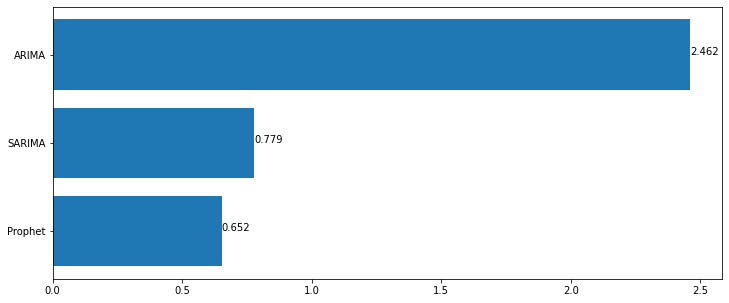

In [45]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [46]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2018-11-30

Great! Now choose the model result you want to see for 2018-11-30
 1.Arima 
 2.Sarimax
 3.Prophet
 3
Choosen Model is prophet
In 2018-11-30 rainfall value for Prophet model:  25.801679084145444


In [47]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Madaripur-monthly_merged.csv")